# INFO 2950 Project Phase IV

By Colin Hoffer, Michael Wang, John Lo, and Patricio Fraga-Errecart

---
## Introduction

**TODO**

---
## Research Questions

- What factors (including education, taxes, weather, etc.) have the highest correlation with typical housing prices in cities in the USA?
- Can such factors be used to accurately predict housing prices within the USA?

---
## Data Collection and Cleaning

The first dataset we decided to use was the Zillow Home Value Index (found [here](https://www.zillow.com/research/data/)) which "reflects the typical value for homes in the 35th to 65th percentile range for a given region." We thought this would be a good estimate of housing prices in various cities. This dataset is organized by metropolitan statistical area (MSA), which usually encompasses multiple counties surrounding a large city. We thought this would give us more accurate and varied data as opposed to using data exclusively within the cities' limits. 


The cities we decided to focus on are: 
- Anchorage, AK
- Birmingham, AL
- Little Rock, AR
- Phoenix, AZ
- Los Angeles, CA
- San Francisco, CA
- Denver, CO
- Washington, DC
- Wilmington, DE
- Miami, FL
- Tampa, FL
- Atlanta, GA
- Honolulu, HI
- Des Moines, IA
- Boise, ID
- Indianapolis, IN
- Chicago, IL
- Kansas City, KS
- Louisville, KY
- New Orleans, LA
- Boston, MA
- Baltimore, MD
- Portland, ME
- Detroit, MI
- Minneapolis, MN
- St. Louis, MO
- Jackson, MS
- Billings, MT
- Charlotte, NC
- Fargo, ND
- Omaha, NE
- Manchester, NH
- Albuquerque, NM
- Las Vegas, NV
- New York, NY
- Cincinatti, OH
- Oklahoma City, OK
- Portland, OR
- Pittsburgh, PA
- Providence, RI
- Columbia, SC
- Sioux Falls, SD
- Nashville, TN
- Dallas, TX
- Houston, TX
- Salt Lake City, UT
- Virginia Beach, VA
- Burlington, VT
- Seattle, WA
- Milwaukee, WI
- Charleston, WV
- Cheyenne, WY  


We thought these choices had a good variety of climate, geography, and demographics.

As for the factors that we want to compare with housing prices, we found a [useful table builder](https://data.census.gov/mdat/#/) on the US Census Website that allowed us to gather data on education completion, household income, gross rent as a percentage of income (used to estimate home affordability), and property taxes for each of the intended MSAs. Unfortunately, these tables were slightly difficult to organize due to the fact that the date could only be organized by counties or districts, not MSAs. To get around this, we downloaded the csv files and consolidated them below so that we had 1 datapoint for each category in each MSA.

We also wanted to see if weather or climate had an effect on housing prices, so we utilized the [NOAA National Weather Service Website](https://w2.weather.gov/climate/) to calculate the Mean High Temperature, Mean Low Temperature, and Mean Annual Temperature in 2018 for each city. 

In addition to these factors, we wanted to analyze the effect of crime on housing prices. We found datasets on the [FBI website](https://ucr.fbi.gov/crime-in-the-u.s/2018/crime-in-the-u.s.-2018/topic-pages/tables/table-6) organized by MSA and year. We chose to record Violent Crime per 100k, Robbery per 100k, Property Crime per 100k, and Burglary per 100k for our our project. **Not all of our cities had data for 2018; in these cases we used data from 2017.**  

We chose to focus on the year 2018, since it was the most recent year that was present in all of our datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import poisson, ttest_ind

In [2]:


chosenCities = ["New York, NY", 
                "Chicago, IL", 
                "Houston, TX", 
                "Boston, MA", 
                "Charlotte, NC",
                "Louisville-Jefferson County, KY", 
                "Cincinnati, OH", 
                "Washington, DC", 
                "Denver, CO", 
                "San Francisco, CA", 
                "Los Angeles-Long Beach-Anaheim, CA", 
                "Miami-Fort Lauderdale, FL", 
                "Seattle, WA", 
                "Atlanta, GA", 
                "Detroit, MI", 
                "Minneapolis, MN", 
                "Phoenix, AZ", 
                "St. Louis, MO", 
                "Albuquerque, NM", 
                "Birmingham, AL", 
                "Boise City, ID",  
                "Dallas-Fort Worth, TX", 
                "Urban Honolulu, HI", 
                "Kansas City, MO", 
                "Las Vegas, NV", 
                "Milwaukee, WI", 
                "Nashville, TN", 
                "Oklahoma City, OK", 
                "Omaha, NE", 
                "Pittsburgh, PA", 
                "Salt Lake City, UT", 
                "Tampa, FL",
                'Portland, OR',
                'Cheyenne, WY',
                'Billings, MT',
                'Fargo, ND',
                'Sioux Falls, SD',
                'Des Moines, IA',
                'Indianapolis, ID',
                'Charleston, WV',
                'Virginia Beach, VA',
                'Columbia, SC',
                'Little Rock, AR',
                'New Orleans, LA',
                'Jackson, MS',
                'Providence, RI',
                'Wilmington, DE',
                'Baltimore, MD',
                'Burlington, VT',
                'Manchester, NH',
                'Portland, ME',
                'Anchorage, AK',
]

In [3]:
##Reading the ZHVI file and creating a base dataframe.
msazhvi = pd.read_csv("MSAZHVI.csv")
msazhvi.head()

##Read the file containing climate and crime data
climatecrime = pd.read_csv("CrimeClimate.csv")

##Averaging out all the ZHVI values for the 12 months in 2018 to obtain 1 value for the entire year.
msazhvi["2018 ZHVI"] = msazhvi["2018-01-31"] + msazhvi["2018-02-28"] + msazhvi["2018-03-31"] + msazhvi["2018-04-30"] + msazhvi["2018-05-31"] + msazhvi["2018-06-30"] + msazhvi["2018-07-31"] + msazhvi["2018-08-31"] + msazhvi["2018-09-30"] + msazhvi["2018-10-31"] + msazhvi["2018-11-30"] + msazhvi["2018-12-31"]
msazhvi["2018 ZHVI"]= msazhvi["2018 ZHVI"]/12

##Renaming columns
msazhvi = msazhvi[["RegionName", "2018 ZHVI"]]

##Choosing cities
msazhvi = msazhvi[msazhvi["RegionName"].isin(chosenCities)]

##Creating columns to be filled
msazhvi["Mean Percent HS/Equivalent Educated"] = np.nan
msazhvi["Mean Percent Bachelor's Degree Holding"] = np.nan
msazhvi["Mean Percent Postgraduate Educated"] = np.nan
msazhvi["Mean Income"] = np.nan
msazhvi["Mean Property Tax"] = np.nan
msazhvi["Mean Rent as a Percentage of Income"] = np.nan

---
Since the census data concerning education is organized differently than the census data on income, taxes, and gross rent as a percentage of income, we needed to initially create two separate .csv files for each city. The following function consolidates the two .csv files into one dataframe.

---

In [4]:

def MSA_data_frame_builder(household, education):
    
    ##Education data set
    ed = pd.read_csv(education)
    ##Housing Data Set
    db = pd.read_csv(household)
    
    ##Column for percentage of population with a high school diploma
    hs_or_equivalent = []
    ##Column for percentage of population with a Bachelor's degree
    bachelors = []
    ##Column for percentage of population with a Postgraduate degree
    postgrad = []
    
    ##for loop that finds the percentages of the population for each column (since the data is raw values, not divided over population)
    for i in range(len(ed["Selected Geographies"])):
        percent = (ed["Regular high school diploma"][i] + ed["GED or alternative credential"][i])/ed["Total"][i]
        hs_or_equivalent.append(percent)
        percent = ed["Bachelor's degree"][i]/ ed["Total"][i]
        bachelors.append(percent)
        percent = (ed["Master's degree"][i] + ed["Professional degree beyond a bachelor's degree"][i] + ed["Doctorate degree"][i])/ ed["Total"][i]
        postgrad.append(percent)
    
    ##inserting averaged data into the data set
    db["HS/Equivalent Education Percentage"] = hs_or_equivalent
    db["Bachelor's Percentage"] = bachelors
    db["Postgraduate Percentage"] = postgrad
    db.insert(loc=2, column="Total Population", value=ed["Total"])
    return db


##creating datasets for each of our cities
SF = MSA_data_frame_builder("Michael's Data/SF.csv", "Michael's Data/SFEducation.csv")
LA = MSA_data_frame_builder("Michael's Data/LA.csv", "Michael's Data/LAEducation.csv")
DE = MSA_data_frame_builder("Michael's Data/Denver.csv", "Michael's Data/DenverEducation.csv")

NY = MSA_data_frame_builder("John's Data/NYC/NYC.csv", "John's Data/NYC/NYCEducation.csv")
BT = MSA_data_frame_builder("John's Data/Boston/Boston.csv", "John's Data/Boston/BostonEducation.csv")
CC = MSA_data_frame_builder("John's Data/Cincinnati/Cincinnati.csv", "John's Data/Cincinnati/CincinnatiEducation.csv")

DC = MSA_data_frame_builder("Patricio's Data/DC/DCHouses.csv", "Patricio's Data/DC/DCEducation.csv")
LV = MSA_data_frame_builder("Patricio's Data/Louisville/LouisvilleHouses.csv", "Patricio's Data/Louisville/LouisvilleEducation.csv")
ST = MSA_data_frame_builder("Patricio's Data/Seattle/SeattleHouses.csv", "Patricio's Data/Seattle/SeattleEducation.csv")

CH = MSA_data_frame_builder("Colin's Data/ChicagoData/Chicago.csv", "Colin's Data/ChicagoData/ChicagoEducation.csv")
HO = MSA_data_frame_builder("Colin's Data/HoustonData/Houston.csv", "Colin's Data/HoustonData/HoustonEducation.csv")
MI = MSA_data_frame_builder("Colin's Data/Miami-Ft.Lauderdale/Miami.csv", "Colin's Data/Miami-Ft.Lauderdale/MiamiEducation.csv")

ATL = MSA_data_frame_builder("Census Data/AtlantaHouses.csv", "Census Data/AtlantaEducation.csv")
DAL = MSA_data_frame_builder("Census Data/DallasHouses.csv", "Census Data/DallasEducation.csv")
DET = MSA_data_frame_builder("Census Data/DetroitHouses.csv", "Census Data/DetroitEducation.csv")
MN = MSA_data_frame_builder("Census Data/MinneapolisHouses.csv", "Census Data/MinneapolisEducation.csv")
PH = MSA_data_frame_builder("Census Data/PhoenixHouses.csv", "Census Data/PhoenixEducation.csv")
STL = MSA_data_frame_builder("Census Data/StLouisHouses.csv", "Census Data/StLouisEducation.csv")
ALB = MSA_data_frame_builder("Census Data/AlbuquerqueHouses.csv", "Census Data/AlbuquerqueEducation.csv")
BH = MSA_data_frame_builder("Census Data/BirminghamHouses.csv", "Census Data/BirminghamEducation.csv")
BO = MSA_data_frame_builder("Census Data/BoiseHouses.csv", "Census Data/BoiseEducation.csv")
CLT = MSA_data_frame_builder("Census Data/CharlotteHouses.csv", "Census Data/CharlotteEducation.csv")
HON = MSA_data_frame_builder("Census Data/HonoluluHouses.csv", "Census Data/HonoluluEducation.csv")
KC = MSA_data_frame_builder("Census Data/KansasCityHouses.csv", "Census Data/KansasCityEducation.csv")
LV = MSA_data_frame_builder("Census Data/LasVegasHouses.csv", "Census Data/LasVegasEducation.csv")
MIL = MSA_data_frame_builder("Census Data/MilwaukeeHouses.csv", "Census Data/MilwaukeeEducation.csv")
NSV = MSA_data_frame_builder("Census Data/NashvilleHouses.csv", "Census Data/NashvilleEducation.csv")
OKC = MSA_data_frame_builder("Census Data/OklahomaCityHouses.csv", "Census Data/OklahomaCityEducation.csv")
OM = MSA_data_frame_builder("Census Data/OmahaHouses.csv", "Census Data/OmahaEducation.csv")
PT = MSA_data_frame_builder("Census Data/PittsburghHouses.csv", "Census Data/PittsburghEducation.csv")
SLC = MSA_data_frame_builder("Census Data/SaltLakeHouses.csv", "Census Data/SaltLakeEducation.csv")
TP = MSA_data_frame_builder("Census Data/TampaHouses.csv", "Census Data/TampaEducation.csv")
POROR = MSA_data_frame_builder("Census Data/PortlandORHouses.csv", "Census Data/PortlandOREducation.csv")
CHE = MSA_data_frame_builder("Census Data/CheyenneHouses.csv", "Census Data/CheyenneEducation.csv")
BIL = MSA_data_frame_builder("Census Data/BillingsHouses.csv", "Census Data/BillingsEducation.csv")
FAR = MSA_data_frame_builder("Census Data/FargoHouses.csv", "Census Data/FargoEducation.csv")
SIO = MSA_data_frame_builder("Census Data/SiouxFallsHouses.csv", "Census Data/SiouxFallsEducation.csv")
DES = MSA_data_frame_builder("Census Data/DesMoinesHouses.csv", "Census Data/DesMoinesEducation.csv")
IND = MSA_data_frame_builder("Census Data/IndianapolisHouses.csv", "Census Data/IndianapolisEducation.csv")
CHA = MSA_data_frame_builder("Census Data/CharlestonHouses.csv", "Census Data/CharlestonEducation.csv")
VIR = MSA_data_frame_builder("Census Data/VirginiaBeachHouses.csv", "Census Data/VirginiaBeachEducation.csv")
COL = MSA_data_frame_builder("Census Data/ColumbiaHouses.csv", "Census Data/ColumbiaEducation.csv")
LIT = MSA_data_frame_builder("Census Data/LittleRockHouses.csv", "Census Data/LittleRockEducation.csv")
ORL = MSA_data_frame_builder("Census Data/NewOrleansHouses.csv", "Census Data/NewOrleansEducation.csv")
JAC = MSA_data_frame_builder("Census Data/JacksonHouses.csv", "Census Data/JacksonEducation.csv")
PRO = MSA_data_frame_builder("Census Data/ProvidenceHouses.csv", "Census Data/ProvidenceEducation.csv")
WIL = MSA_data_frame_builder("Census Data/WilmingtonHouses.csv", "Census Data/WilmingtonEducation.csv")
BAL = MSA_data_frame_builder("Census Data/BaltimoreHouses.csv", "Census Data/BaltimoreEducation.csv")
BUR = MSA_data_frame_builder("Census Data/BurlingtonHouses.csv", "Census Data/BurlingtonEducation.csv")
MAN = MSA_data_frame_builder("Census Data/ManchesterHouses.csv", "Census Data/ManchesterEducation.csv")
PORME = MSA_data_frame_builder("Census Data/PortlandMEHouses.csv", "Census Data/PortlandMEEducation.csv")
ANC = MSA_data_frame_builder("Census Data/AnchorageHouses.csv", "Census Data/AnchorageEducation.csv")


---
All of the data we collected from the census website is organized by counties, and not MSAs like our Zillow data. The following function finds the weighted means of every factor (education, income, etc.) based on the relative populations and the number of households within the MSAs. These weighted means are then added to the original ZHVI dataframe.

---

In [5]:
##Function finds the weighted means of each Metropolitan Statistical Area (utilizing county data). Takes in a name and a dataframe
def weightedMeans(location, MSAdata):
    hs = 0
    bach = 0
    post = 0
    inc = 0
    tax = 0
    grpip = 0
    mht = climatecrime.loc[climatecrime["MSA"] == location, "Mean High Temp"].iloc[0]
    mlt = climatecrime.loc[climatecrime["MSA"] == location, "Mean Low Temp"].iloc[0]
    mat = climatecrime.loc[climatecrime["MSA"] == location, "Mean Annual Temp"].iloc[0]
    vioc = climatecrime.loc[climatecrime["MSA"] == location, "Violent Crime per 100k"].iloc[0]
    robc = climatecrime.loc[climatecrime["MSA"] == location, "Robbery per 100k"].iloc[0]
    proc = climatecrime.loc[climatecrime["MSA"] == location, "Property Crime per 100k"].iloc[0]
    burc = climatecrime.loc[climatecrime["MSA"] == location, "Burglary per 100k"].iloc[0]
    
    totalHouses = MSAdata["Households"].sum()
    totalPop = MSAdata["Total Population"].sum()
    
    
    for i in range(len(MSAdata.index)):
        hs += MSAdata["HS/Equivalent Education Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        bach += MSAdata["Bachelor's Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        post += MSAdata["Postgraduate Percentage"][i]*MSAdata["Total Population"][i]/totalPop
        inc += MSAdata["Household income (past 12 months, use ADJINC to adjust HINCP to constant dollars)"][i]*MSAdata["Households"][i]/totalHouses
        tax += MSAdata["Property taxes (yearly real estate taxes)"][i]*MSAdata["Households"][i]/totalHouses
        grpip += MSAdata["Gross rent as a percentage of household income past 12 months"][i]*MSAdata["Households"][i]/totalHouses
    
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Percent HS/Equivalent Educated"] = hs
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Percent Bachelor's Degree Holding"] = bach
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Percent Postgraduate Educated"] = post
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Income"] = inc
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Property Tax"] = tax
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Rent as a Percentage of Income"] = grpip
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean High Temp"] = mht
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Low Temp"] = mlt
    msazhvi.loc[(msazhvi["RegionName"] == location), "Mean Annual Temp"] = mat
    msazhvi.loc[(msazhvi["RegionName"] == location), "Violent Crime per 100k"] = vioc
    msazhvi.loc[(msazhvi["RegionName"] == location), "Robbery per 100k"] = robc
    msazhvi.loc[(msazhvi["RegionName"] == location), "Property Crime per 100k"] = proc
    msazhvi.loc[(msazhvi["RegionName"] == location), "Burglary per 100k"] = burc

weightedMeans("San Francisco, CA", SF)
weightedMeans("Los Angeles-Long Beach-Anaheim, CA", LA)
weightedMeans("Denver, CO", DE)

weightedMeans("New York, NY", NY)
weightedMeans("Boston, MA", BT)
weightedMeans("Cincinnati, OH", CC)

weightedMeans("Washington, DC", DC)
weightedMeans("Louisville-Jefferson County, KY", LV)
weightedMeans("Seattle, WA", ST)

weightedMeans("Chicago, IL", CH)
weightedMeans("Houston, TX", HO)
weightedMeans("Miami-Fort Lauderdale, FL", MI)

weightedMeans('Atlanta, GA', ATL)
weightedMeans('Dallas-Fort Worth, TX', DAL)
weightedMeans('Detroit, MI', DET)
weightedMeans('Minneapolis, MN', MN)
weightedMeans('Phoenix, AZ', PH)
weightedMeans('St. Louis, MO', STL)

weightedMeans('Albuquerque, NM', ALB)
weightedMeans('Birmingham, AL', BH)
weightedMeans('Boise City, ID', BO)
weightedMeans('Charlotte, NC', CLT)
weightedMeans('Urban Honolulu, HI', HON)
weightedMeans('Kansas City, MO', KC)
weightedMeans('Milwaukee, WI', MIL)
weightedMeans('Las Vegas, NV', LV)
weightedMeans('Nashville, TN', NSV)
weightedMeans('Oklahoma City, OK', OKC)
weightedMeans('Omaha, NE', OM)
weightedMeans('Pittsburgh, PA', PT)
weightedMeans('Salt Lake City, UT', SLC)
weightedMeans('Tampa, FL', TP)

weightedMeans('Portland, OR', POROR)
weightedMeans('Cheyenne, WY', CHE)
weightedMeans('Billings, MT', BIL)
weightedMeans('Fargo, ND', FAR)
weightedMeans('Sioux Falls, SD', SIO)
weightedMeans('Des Moines, IA', DES)
weightedMeans('Indianapolis, ID', IND)
weightedMeans('Charleston, WV', CHA)
weightedMeans('Virginia Beach, VA', VIR)
weightedMeans('Columbia, SC', COL)
weightedMeans('Little Rock, AR', LIT)
weightedMeans('New Orleans, LA', ORL)
weightedMeans('Jackson, MS', JAC)
weightedMeans('Providence, RI', PRO)
weightedMeans('Wilmington, DE', WIL)
weightedMeans('Baltimore, MD', BAL)
weightedMeans('Burlington, VT', BUR)
weightedMeans('Manchester, NH', MAN)
weightedMeans('Portland, ME', PORME)
weightedMeans('Anchorage, AK', ANC)



msazhvi

,RegionName,2018 ZHVI,Mean Percent HS/Equivalent Educated,Mean Percent Bachelor's Degree Holding,Mean Percent Postgraduate Educated,Mean Income,Mean Property Tax,Mean Rent as a Percentage of Income,Mean High Temp,Mean Low Temp,Mean Annual Temp,Violent Crime per 100k,Robbery per 100k,Property Crime per 100k,Burglary per 100k
1,"New York, NY",4.702898e+05,0.194727,0.181194,0.123487,97918.579350,4080.629834,16.965818,97.0,5.0,53.4,332.9,107.5,1335.6,152.6
2,"Los Angeles-Long Beach-Anaheim, CA",6.584842e+05,0.163148,0.166903,0.083846,91473.680944,2495.099228,19.548604,101.0,38.0,66.0,494.8,162.7,2246.9,390.5
3,"Chicago, IL",2.363690e+05,0.196159,0.170818,0.105563,84038.028714,3621.713256,11.552303,95.0,-7.0,50.5,443.0,166.8,2081.6,330.7
4,"Dallas-Fort Worth, TX",2.402137e+05,0.178769,0.159131,0.083052,83355.597543,2734.003335,13.185533,106.0,18.0,68.0,351.0,103.6,2232.7,360.9
6,"Houston, TX",2.076934e+05,0.182125,0.140816,0.077357,75547.037009,2507.561749,12.354341,103.0,26.0,70.3,593.1,176.7,2604.7,443.5
7,"Washington, DC",4.165819e+05,0.141638,0.198190,0.184021,123028.151092,2998.814976,12.758984,99.0,13.0,59.0,264.8,84.3,1656.8,137.9
8,"Miami-Fort Lauderdale, FL",2.871426e+05,0.207246,0.162260,0.099602,60800.129049,1837.925430,14.352038,95.0,42.0,77.5,427.7,116.3,2781.1,315.1
9,"Atlanta, GA",2.218861e+05,0.189890,0.171760,0.101076,81266.775866,1559.728686,11.909968,97.0,15.0,63.3,320.7,94.1,2575.0,393.9
10,"Boston, MA",4.790218e+05,0.172954,0.204811,0.165631,108235.822458,3530.419099,14.053450,97.0,2.0,52.1,284.4,54.4,1167.3,151.2
11,"San Francisco, CA",1.103116e+06,0.130278,0.234833,0.158303,136294.213613,3939.445843,14.528505,93.0,39.0,57.8,472.4,217.6,3283.5,400.9


---
## Data Description

In our final dataset (msazhvi), the rows represent 52 Metropolitan Statistical Areas (MSAs) throughout different geographical regions of the US. The columns are different attributes of each MSA, including average home value (2018 ZHVI), highest education attained, income, property taxes, and rent as a percent of income. This dataset was created to interpret our data easier. We had many different observations and calculations that culminated into our final data frame. All data was free and we required no funding, but it came from places like the census and .gov sources. The processes where we ignored data came from looking at the country geographically and choosing cities from diversified areas. We recorded data that we felt could have an impact on housing prices, and other metrics that may be reflective of wealthy areas. We preprocessed some data in excel to make it easier to be called on later for each city. The census did not allow multiple variables at once, so every city had 5 different downloads alone to create two .csv files for the city. People were involved and they were aware, since they had filled out the census. Our data sources are linked in the data collection section

# Education, Income, Property Tax, Rent Data Analysis

In [6]:
##giving different weights to each level of education so we create an education score later 
msazhvi['Education Score'] = msazhvi['Mean Percent HS/Equivalent Educated'] + 1.8*msazhvi["Mean Percent Bachelor's Degree Holding"] + 2.3*msazhvi['Mean Percent Postgraduate Educated']

In [7]:
model = LinearRegression()
model.fit(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])

LinearRegression()

In [8]:
print('Education Score Slope: ' + str(model.coef_[0]))
print('Income Slope: ' + str(model.coef_[1]))
print('Property Tax Slope: ' + str(model.coef_[2]))
print('RPI Slope: ' + str(model.coef_[3]))

Education Score Slope: 306075.3014445355
Income Slope: 5.533112671592572
Property Tax Slope: -26.1458221947378
RPI Slope: 22793.45804375338


In [9]:
msazhvi['Predictions'] = model.predict(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']])
msazhvi['Difference'] = msazhvi['2018 ZHVI'] - msazhvi['Predictions']

In [10]:
print('R-Squared: ' + str(model.score(msazhvi[['Education Score', 'Mean Income', 'Mean Property Tax', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])))

R-Squared: 0.6473844514048217


R-Squared: 0.269555059379747


Text(0, 0.5, '2018 ZHVI')

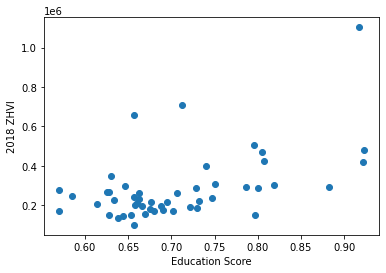

In [11]:
edModel = LinearRegression()
edModel.fit(msazhvi[['Education Score']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(edModel.score(msazhvi[['Education Score']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Education Score'], msazhvi['2018 ZHVI'])
plt.xlabel('Education Score')
plt.ylabel('2018 ZHVI')

R-Squared: 0.573268016993109


Text(0, 0.5, '2018 ZHVI')

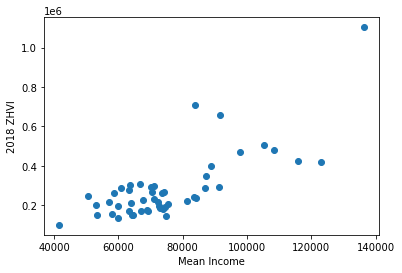

In [12]:
incModel = LinearRegression()
incModel.fit(msazhvi[['Mean Income']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(incModel.score(msazhvi[['Mean Income']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Income'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Income')
plt.ylabel('2018 ZHVI')

R-Squared: 0.27088037454887315


Text(0, 0.5, '2018 ZHVI')

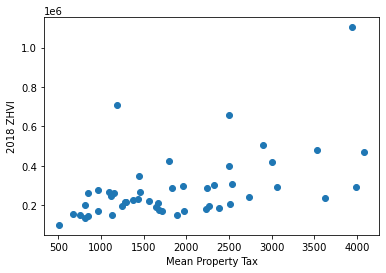

In [13]:
taxModel = LinearRegression()
taxModel.fit(msazhvi[['Mean Property Tax']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(taxModel.score(msazhvi[['Mean Property Tax']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Property Tax'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Property Tax')
plt.ylabel('2018 ZHVI')

R-Squared: 0.33977823963445


Text(0, 0.5, '2018 ZHVI')

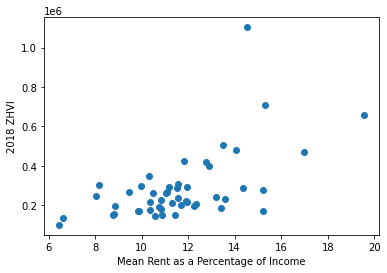

In [14]:
rentModel = LinearRegression()
rentModel.fit(msazhvi[['Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])
print('R-Squared: ' + str(rentModel.score(msazhvi[['Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])))
plt.scatter(msazhvi['Mean Rent as a Percentage of Income'], msazhvi['2018 ZHVI'])
plt.xlabel('Mean Rent as a Percentage of Income')
plt.ylabel('2018 ZHVI')

<IPython.core.display.Javascript object>


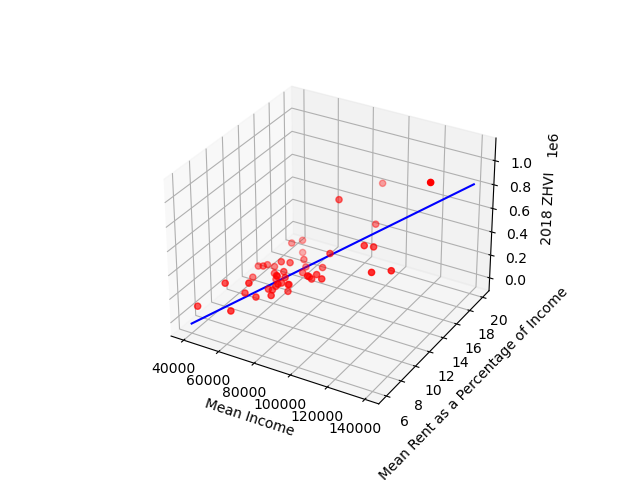

In [15]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

twoDModel = LinearRegression()
twoDModel.fit(msazhvi[['Mean Income', 'Mean Rent as a Percentage of Income']], msazhvi['2018 ZHVI'])

inc_pred = np.linspace(40000, 140000, 200)
RPI_pred = np.linspace(6, 20, 200)

x, y = np.meshgrid(inc_pred, RPI_pred)

samples = pd.DataFrame({'Income':inc_pred, 'RPI':RPI_pred})

#samples = pd.DataFrame({'Income':x, 'RPI':y})

pred = twoDModel.predict(samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(msazhvi['Mean Income'], msazhvi['Mean Rent as a Percentage of Income'], msazhvi['2018 ZHVI'], c='r')
ax.plot(inc_pred, RPI_pred, pred, c='blue')
ax.legend
ax.set_xlabel('Mean Income')
ax.set_ylabel('Mean Rent as a Percentage of Income')
ax.set_zlabel('2018 ZHVI')

plt.show()

In [16]:
msazhvi

,RegionName,2018 ZHVI,Mean Percent HS/Equivalent Educated,Mean Percent Bachelor's Degree Holding,Mean Percent Postgraduate Educated,Mean Income,Mean Property Tax,Mean Rent as a Percentage of Income,Mean High Temp,Mean Low Temp,Mean Annual Temp,Violent Crime per 100k,Robbery per 100k,Property Crime per 100k,Burglary per 100k,Education Score,Predictions,Difference
1,"New York, NY",4.702898e+05,0.194727,0.181194,0.123487,97918.579350,4080.629834,16.965818,97.0,5.0,53.4,332.9,107.5,1335.6,152.6,0.804896,505000.015479,-34710.182145
2,"Los Angeles-Long Beach-Anaheim, CA",6.584842e+05,0.163148,0.166903,0.083846,91473.680944,2495.099228,19.548604,101.0,38.0,66.0,494.8,162.7,2246.9,390.5,0.656419,524220.019581,134264.147086
3,"Chicago, IL",2.363690e+05,0.196159,0.170818,0.105563,84038.028714,3621.713256,11.552303,95.0,-7.0,50.5,443.0,166.8,2081.6,330.7,0.746426,298907.126671,-62538.126671
4,"Dallas-Fort Worth, TX",2.402137e+05,0.178769,0.159131,0.083052,83355.597543,2734.003335,13.185533,106.0,18.0,68.0,351.0,103.6,2232.7,360.9,0.656225,327959.613577,-87745.946911
6,"Houston, TX",2.076934e+05,0.182125,0.140816,0.077357,75547.037009,2507.561749,12.354341,103.0,26.0,70.3,593.1,176.7,2604.7,443.5,0.613515,258656.279059,-50962.862392
7,"Washington, DC",4.165819e+05,0.141638,0.198190,0.184021,123028.151092,2998.814976,12.758984,99.0,13.0,59.0,264.8,84.3,1656.8,137.9,0.921629,612059.799458,-195477.882792
8,"Miami-Fort Lauderdale, FL",2.871426e+05,0.207246,0.162260,0.099602,60800.129049,1837.925430,14.352038,95.0,42.0,77.5,427.7,116.3,2781.1,315.1,0.728399,275265.971446,11876.611887
9,"Atlanta, GA",2.218861e+05,0.189890,0.171760,0.101076,81266.775866,1559.728686,11.909968,97.0,15.0,63.3,320.7,94.1,2575.0,393.9,0.731531,341079.204141,-119193.120808
10,"Boston, MA",4.790218e+05,0.172954,0.204811,0.165631,108235.822458,3530.419099,14.053450,97.0,2.0,52.1,284.4,54.4,1167.3,151.2,0.922565,546104.934814,-67083.184814
11,"San Francisco, CA",1.103116e+06,0.130278,0.234833,0.158303,136294.213613,3939.445843,14.528505,93.0,39.0,57.8,472.4,217.6,3283.5,400.9,0.917072,699807.711716,403308.704950


# Crime Data Analysis

In [17]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [18]:
crimemodel = LinearRegression()
crimemodel.fit(msazhvi[["Violent Crime per 100k", "Robbery per 100k", "Property Crime per 100k", "Burglary per 100k"]], msazhvi["2018 ZHVI"])

LinearRegression()

In [19]:
print('Violent Crime Slope: ' + str(crimemodel.coef_[0]))
print('Robbery Slope: ' + str(crimemodel.coef_[1]))
print('Property Crime Slope: ' + str(crimemodel.coef_[2]))
print('Burglary Slope: ' + str(crimemodel.coef_[3]))

Violent Crime Slope: -624.8154870739698
Robbery Slope: 2179.2962907031138
Property Crime Slope: 61.297186361444346
Burglary Slope: -249.272485455714


In [20]:
msazhvi["Crime Predictions"] = crimemodel.predict(msazhvi[["Violent Crime per 100k", "Robbery per 100k", "Property Crime per 100k", "Burglary per 100k"]])
msazhvi['Crime Difference'] = msazhvi['2018 ZHVI'] - msazhvi['Crime Predictions']

In [21]:
print("Crime R-squared: " + str(crimemodel.score(msazhvi[["Violent Crime per 100k", "Robbery per 100k", "Property Crime per 100k", "Burglary per 100k"]], msazhvi["2018 ZHVI"])))

Crime R-squared: 0.35645850089946995


In [22]:
vioModel = LinearRegression()
vioModel.fit(msazhvi[["Violent Crime per 100k"]], msazhvi['2018 ZHVI'])
print('Violent Crime R-Squared: ' + str(vioModel.score(msazhvi[['Violent Crime per 100k']], msazhvi['2018 ZHVI'])))

Violent Crime R-Squared: 0.028540399915862324


In [23]:
robModel = LinearRegression()
robModel.fit(msazhvi[["Robbery per 100k"]], msazhvi['2018 ZHVI'])
print('Robbery R-Squared: ' + str(robModel.score(msazhvi[['Robbery per 100k']], msazhvi['2018 ZHVI'])))

Robbery R-Squared: 0.03711749785655449


In [24]:
propModel = LinearRegression()
propModel.fit(msazhvi[["Property Crime per 100k"]], msazhvi['2018 ZHVI'])
print('Property Crime R-Squared: ' + str(propModel.score(msazhvi[['Property Crime per 100k']], msazhvi['2018 ZHVI'])))

Property Crime R-Squared: 4.189075171046053e-05


In [25]:
burgModel = LinearRegression()
burgModel.fit(msazhvi[["Burglary per 100k"]], msazhvi['2018 ZHVI'])
print('Burglary R-Squared: ' + str(burgModel.score(msazhvi[['Burglary per 100k']], msazhvi['2018 ZHVI'])))

Burglary R-Squared: 0.028785687966914275


In [26]:
##propCrimeArray = msazhvi["Property Crime per 100k"].to_numpy().astype(int)
##zhviArray = msazhvi['2018 ZHVI'].to_numpy().astype(int)